In [1094]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import networkx as nx
import peartree as pear
import partridge as ptg
import matplotlib.pyplot as plt

In [1095]:
import warnings
warnings.filterwarnings('ignore')

In [1096]:
feed = pear.get_representative_feed("gtfs_subway/")

In [1097]:
start_time = 8 * 60 * 60
end_time = 20 * 60 * 60
base = pear.load_feed_as_graph(feed, start_time, end_time).to_undirected()

In [1098]:
G = base.copy()

In [1099]:
stops=list(G.nodes())
G.nodes.data()

NodeDataView({'DETIR_101': {'boarding_cost': 154.29358640746977, 'modes': ['1'], 'y': 40.889248, 'x': -73.898583}, 'DETIR_103': {'boarding_cost': 150.56834742057708, 'modes': ['1'], 'y': 40.884667, 'x': -73.90087}, 'DETIR_104': {'boarding_cost': 150.02894076789502, 'modes': ['1'], 'y': 40.878856, 'x': -73.904834}, 'DETIR_106': {'boarding_cost': 150.02894076789505, 'modes': ['1'], 'y': 40.874561, 'x': -73.909831}, 'DETIR_107': {'boarding_cost': 147.94520547945206, 'modes': ['1'], 'y': 40.869444, 'x': -73.915279}, 'DETIR_108': {'boarding_cost': 147.94520547945206, 'modes': ['1'], 'y': 40.864621, 'x': -73.918822}, 'DETIR_109': {'boarding_cost': 147.44199049482808, 'modes': ['1'], 'y': 40.860531, 'x': -73.925536}, 'DETIR_110': {'boarding_cost': 147.94520547945206, 'modes': ['1'], 'y': 40.855225, 'x': -73.929412}, 'DETIR_111': {'boarding_cost': 147.44199049482808, 'modes': ['1'], 'y': 40.849505, 'x': -73.933596}, 'DETIR_112': {'boarding_cost': 146.9387755102041, 'modes': ['1'], 'y': 40.8405

In [1100]:
stops = [stop[-3:] for stop in stops]

station_data = pd.read_csv("MTA_Subway_Stations.csv")
station_data = station_data[['GTFS Stop ID', 'Complex ID', 'Stop Name', 'Daytime Routes']]

rl = [str(r).split() for r in station_data['Daytime Routes']]
station_data['Daytime Routes'] = rl
station_data

,GTFS Stop ID,Complex ID,Stop Name,Daytime Routes
0,127,611,Times Sq-42 St,"[1, 2, 3]"
1,S17,515,Annadale,[SIR]
2,S01,627,Franklin Av,[S]
3,254,349,Junius St,[3]
4,M01,108,Middle Village-Metropolitan Av,[M]
...,...,...,...,...
491,B06,222,Roosevelt Island,[F]
492,J15,83,Woodhaven Blvd,"[J, Z]"
493,S18,514,Eltingville,[SIR]
494,F14,232,2 Av,[F]


In [1101]:
# PostProcessing graph
dn = dict(G.nodes.items())
kl = list(dn.keys())

for k in kl:
	m = k[-3:]
	ls = station_data[station_data['GTFS Stop ID'] == m]
	G.nodes[k]['lines'] = ls.iat[0,3]
	G.nodes[k]['GTFS ID'] = ls.iat[0,0]
	G.nodes[k]['Station Name'] = ls.iat[0,2]
	G.nodes[k]['Complex ID'] = str(ls.iat[0,1])
	try: del G.nodes[k]['modes']
	except KeyError: continue
nx.relabel_nodes(G, lambda x: x[-3:], copy=False)
G.edges.data()
el = list(dict(G.edges.items()))
for e in el:
	try: del G.edges[e]['mode']
	except KeyError: continue

In [1102]:
# remove Staten Island Railroad

stps = list(dict(G.nodes.items()).keys())
for stp in stps:
	if 'SIR' in G.nodes[stp]['lines']:
		G.remove_node(stp)


In [1103]:
## Add routes to edges
edgelist = G.edges.keys()
for edge in edgelist:
	stop1 = edge[0]
	stop2 = edge[1]
	edge_lines = set(G.nodes[stop1]['lines']).intersection(G.nodes[stop2]['lines'])
	G.edges[edge]['lines'] = edge_lines


In [1104]:
## transfers in complex
transfers = pd.read_csv('gtfs_subway/transfers.txt')
transfers['lines'] = 0
for i in range(len(transfers['from_stop_id'])):
	coming = transfers['from_stop_id'][i]
	going = transfers['to_stop_id'][i]

	try: 
		d = (G.nodes[coming]['lines'], G.nodes[going]['lines'])
		transfers['lines'][i] = d
	except Exception as e:
		print(e)
		print(coming, going, i)
	
transfers.drop("transfer_type", inplace=True, axis=1)

transfers = transfers[transfers['from_stop_id'] != transfers['to_stop_id']]
transfers.reset_index(inplace=True,drop=True)

In [1105]:
S = [s for s in nx.connected_components(G)]
## 5 disconnected components without complexes
## S[0] is the IRT
## S[1] is the 7 train, and possibly express?
## S[2] is the 42 street shuttle
## S[3] is the BMT/IND
## S[4] is the L train
import itertools
def iterator(L):
	a, b = itertools.tee(L)
	next(b, None)
	return list(zip(a,b))


In [1106]:
complexes = pd.read_csv("MTA_Subway_Stations_and_Complexes_20250918.csv")
complexes = complexes[complexes['Number Of Stations In Complex'] > 1]
complexes = complexes[['Complex ID','Number Of Stations In Complex', 'GTFS Stop IDs']]
gtfs_ids = [ids.split("; ") for ids in complexes['GTFS Stop IDs']]
complex_pairs = [list(itertools.combinations(sts, 2)) for sts in gtfs_ids]
complexes['complex_transfers'] = complex_pairs
complexes = complexes.explode('complex_transfers', ignore_index=True).drop(['Number Of Stations In Complex','GTFS Stop IDs'], axis= 1)
transfer_edges = list(zip(transfers['from_stop_id'], transfers['to_stop_id']))
transfer_edge_set = set()
for k in transfer_edges:
	transfer_edge_set.add(tuple(sorted(k)))

##print(transfer_edge_set ^ set(complexes['complex_transfers']))
##('254', 'L26'), ('629', 'B08'), ('B08', 'R11')##

## Out of station transfers specified on the official map
## Walk Junius to Livonia
## Walk Lexington-59 NRW to Lexington-63 -- 300s
## walk Lexington-59 456 to Lexington-63 -- 300s
transfers['edges'] = [tuple(sorted(k)) for k in transfer_edges]
unique_transfers = transfers.sort_values('edges').iloc[::2,:]
unique_transfers.reset_index(drop=True,inplace=True)
unique_transfers.drop(['from_stop_id', 'to_stop_id'], axis=1, inplace=True)

In [1107]:
for u, v, data in G.edges(data=True):
    try:
        data["time"] = data.pop("length")
    except: continue


In [1108]:
fstop = [unique_transfers['edges'][k][0] for k in unique_transfers.index]
tstop = [unique_transfers['edges'][k][1] for k in unique_transfers.index]
ttime = unique_transfers['min_transfer_time']
weighted_edge_list = list(zip(fstop, tstop, ttime))
G.add_weighted_edges_from(weighted_edge_list, weight='time',lines=set(["Transfer"]))


In [1109]:
C = [s for s in nx.connected_components(G)]
len(C)

##nx.relabel_nodes(G, lambda x: G.nodes[x]['Complex ID'], copy=False)

1

In [1110]:
elist = list(G.edges.data())
edict = {}
for i in range(len(elist)):
	start =elist[i][0]
	stop = elist[i][1]
	data = elist[i][2]
	edict[(start, stop)] = data


In [1111]:
node_data = pd.DataFrame.from_dict(dict(G.nodes.data()))
edge_list2 = list(G.edges.data(True))
edge_list_pairs = {}
for e in edge_list2:
	edge_list_pairs[(e[0], e[1])] = e[2]

edge_data = pd.DataFrame.from_dict(edge_list_pairs).T


In [1112]:
## rename 6x and 7x (ignore skip stop)
seven_express = edge_data[['7' in k for k in edge_data['lines']]]
seven_express
## non express edges 
# 710-709
# 709-708
# 708-707
# 707-706
# 706-705
# 705-702

## express only
# 710-707
# 707-702

not7x = [('710', '709',0), ('709','708'),('708','707'),('707','706'),('706','705')]
only7x = [('710', '707'), ('707','702')]
for edge in seven_express.index:
	edgek = (edge[0], edge[1], 0)
	if edge not in not7x:
		G.edges[edgek]['lines'].add("7x")
	
for edge in only7x:
	edgek = (edge[0], edge[1], 0)
	try:
		G.edges[edgek]['lines'].remove('7')
	except KeyError: continue


In [1113]:
six_express = edge_data[['6' in k for k in edge_data['lines']]]
six_express

## non express edges
# 619, 618, 617, 616, 615, 614, 613, 612, 611, 610, 609, 608
## express only
# 619, 613, 608

not6x = [tuple([str(c) for c in d]) for d in iterator(range(608, 620))]
only6x = [('619', '613'), ('613', '608')]
for edge in six_express.index:
	edgek = (edge[0], edge[1], 0)
	if edge not in not6x:
		G.edges[edgek]['lines'].add("6x")
	
for edge in only6x:
	edgek = (edge[0], edge[1], 0)
	try:
		G.edges[edgek]['lines'].remove('6')
	except KeyError: continue

In [1114]:
non_express_nodes_6 = [str(k) for k in [618, 617, 616, 615, 614, 612, 611, 610, 609]]
for n in G.nodes:
	if '6' in G.nodes[n]['lines']:
		if n not in non_express_nodes_6:
			if '6x' not in G.nodes[n]['lines']:
				G.nodes[n]['lines'].append('6x')


non_express_nodes_7 = [str(k) for k in [709, 708, 706, 705]]
for n in G.nodes:
	if '7' in G.nodes[n]['lines']:
		if n not in non_express_nodes_7:
			if '7x' not in G.nodes[n]['lines']:
				G.nodes[n]['lines'].append('7x')

In [1115]:
G.nodes.data()

NodeDataView({'101': {'boarding_cost': 154.29358640746977, 'y': 40.889248, 'x': -73.898583, 'lines': ['1'], 'GTFS ID': '101', 'Station Name': 'Van Cortlandt Park-242 St', 'Complex ID': '293'}, '103': {'boarding_cost': 150.56834742057708, 'y': 40.884667, 'x': -73.90087, 'lines': ['1'], 'GTFS ID': '103', 'Station Name': '238 St', 'Complex ID': '294'}, '104': {'boarding_cost': 150.02894076789502, 'y': 40.878856, 'x': -73.904834, 'lines': ['1'], 'GTFS ID': '104', 'Station Name': '231 St', 'Complex ID': '295'}, '106': {'boarding_cost': 150.02894076789505, 'y': 40.874561, 'x': -73.909831, 'lines': ['1'], 'GTFS ID': '106', 'Station Name': 'Marble Hill-225 St', 'Complex ID': '296'}, '107': {'boarding_cost': 147.94520547945206, 'y': 40.869444, 'x': -73.915279, 'lines': ['1'], 'GTFS ID': '107', 'Station Name': '215 St', 'Complex ID': '297'}, '108': {'boarding_cost': 147.94520547945206, 'y': 40.864621, 'x': -73.918822, 'lines': ['1'], 'GTFS ID': '108', 'Station Name': '207 St', 'Complex ID': '298

In [1116]:
el = list(G.edges(data=True))

for i in range(len(el)):
	q = (el[i][0], el[i][1])
	d = el[i][2]
	el[i] = [q,d]

edf = pd.DataFrame([k[1] for k in el], index= [k[0] for k in el])
ndf = pd.DataFrame.from_dict(dict(G.nodes(data=True))).T


In [1117]:
## Deal with skip-stop and peak direction only lines
## it can't be that bad right (it was)
possibly_wrong = edf[edf['lines'].map(len) > 1]
edges = np.transpose([list(k) for k in possibly_wrong.index])
stop_names = pd.DataFrame(data=list(station_data['Stop Name']), index=station_data['GTFS Stop ID'], columns=['stop name'])
possibly_wrong['stop1'] = [stop_names.loc[s]['stop name'] for s in edges[0]]
possibly_wrong['stop2'] = [stop_names.loc[s]['stop name'] for s in edges[1]]
stop1_counts = dict(possibly_wrong['stop1'].value_counts(sort=False))
stop2_counts = dict(possibly_wrong['stop2'].value_counts(sort=False))
possibly_wrong['stop 1 count'] = [stop1_counts[s] for s in possibly_wrong['stop1']]
possibly_wrong['stop 2 count'] = [stop2_counts[s] for s in possibly_wrong['stop2']]

possibly_wrong.sort_values('lines', key=lambda s: s.str.len(), ascending=True, inplace=True)


In [1118]:
newfile = possibly_wrong.explode(['lines']).reset_index()
newfile

,index,lines,time,stop1,stop2,stop 1 count,stop 2 count
0,"(120, 227)",2,275.284974,96 St,110 St-Malcolm X Plaza,4,2
1,"(120, 227)",3,275.284974,96 St,110 St-Malcolm X Plaza,4,2
2,"(213, 221)",2,685.909091,E 180 St,3 Av-149 St,2,2
3,"(213, 221)",5,685.909091,E 180 St,3 Av-149 St,2,2
4,"(214, 215)",2,120.000000,West Farms Sq-E Tremont Av,174 St,1,1
...,...,...,...,...,...,...,...
561,"(235, 239)",3,310.555556,Atlantic Av-Barclays Ctr,Franklin Av-Medgar Evers College,5,2
562,"(234, 235)",2,90.000000,Nevins St,Atlantic Av-Barclays Ctr,2,1
563,"(234, 235)",5,90.000000,Nevins St,Atlantic Av-Barclays Ctr,2,1
564,"(234, 235)",4,90.000000,Nevins St,Atlantic Av-Barclays Ctr,2,1


In [1119]:
## doing this by hand is a pain but i don't know how else to do this
non_edges = pd.read_csv("possibly_wrong_no_skip.csv")
non_edges = non_edges.drop(non_edges.columns[2:], axis=1)
non_edges = non_edges.groupby('stops').agg({'lines': lambda x: set(x)},)
non_edges.reset_index(inplace=True)
stoplists = np.transpose([list(eval(w)) for w in non_edges['stops']])
non_edges['stop1'] = stoplists[0]
non_edges['stop2'] = stoplists[1]
non_edges.drop('stops', axis=1, inplace=True)
non_edges = non_edges[['stop1', 'stop2', 'lines']]

In [1120]:
for stop1, stop2, lines in non_edges.values:
	try:
		all_lines: set = G.edges[stop1,stop2,0]['lines']
		G.edges[stop1,stop2,0]['lines'] = all_lines - lines
	except:
		print(stop1, stop2, lines)
		break


In [1121]:
# remove the <F> express
f = []

for i in G.edges(data=True):
	if i[2]['lines'] & set("F"):
		f.append([i[0],i[1]])

f = np.transpose(f)
f_stop1 = [stop_names.loc[s]['stop name'] for s in f[0]]
f_stop2 = [stop_names.loc[s]['stop name'] for s in f[1]]

f_edges= pd.DataFrame(np.transpose([f[0], f[1], f_stop1, f_stop2]), columns=['stop_id_1', 'stop_id_2', 'stop name 1', 'stop name 2'])
f_order = pd.read_csv("flocal.csv")
f_order = {v: k for k,v in dict(f_order['stop_id']).items()}
f_edges['order'] = [(f_order[x], f_order[y]) for x,y in zip(f_edges['stop_id_1'], f_edges['stop_id_2'])]
f_edges.sort_values('order', inplace=True)
f_delta = [np.abs(i[0] - i[1]) != 1 for i in f_edges['order']]
fd = list(zip(f_edges[f_delta]['stop_id_1'],f_edges[f_delta]['stop_id_2']))
for i,j in fd: 
	G.remove_edge(i,j) 

In [1122]:
fd

[('F01', 'F03'), ('F03', 'F06'), ('A41', 'F24'), ('F24', 'F27')]

### Fix edge weights so that boarding cost varies by line

In [1123]:
tripline = list(feed.stop_times['trip_id'])
inseq = feed.stop_times.copy()
tripdict = {k: v for k,v in zip(feed.trips['trip_id'], feed.trips['route_id'])}
feed.stop_times['lines'] = [tripdict[s] for s in feed.stop_times['trip_id']]
feed.stop_times['dir'] = [s[-4] if s[-4] != 'X' else s[-7] for s in feed.stop_times['trip_id']]
stoptime = pd.DataFrame(feed.stop_times).copy()
stoptime = stoptime[stoptime['arrival_time'].between(start_time, end_time)]
stoptime = stoptime[stoptime['lines'] != 'SI']
stoptime.sort_values(['stop_id','lines', 'dir', 'arrival_time'], inplace=True)

In [1124]:
seq_dict = {}
for n, g in inseq.groupby('trip_id'):
	seq_dict[n] = len(g['stop_sequence'])

In [1125]:
stoptime.sort_values('trip_id', inplace=True)
stoptime['trip_len'] = [seq_dict[n] for n in stoptime['trip_id']]
stops_in_time = dict(stoptime.trip_id.value_counts())
stoptime['count_in_timespan'] = [stops_in_time[n] for n in stoptime.trip_id]
stoptime = stoptime[stoptime['count_in_timespan'] == stoptime['trip_len']]

In [1126]:
stgroups = stoptime.groupby(['stop_id', 'lines','dir'], group_keys=True)
st_weights = pd.DataFrame(list(stgroups.groups.keys()),index=list(stgroups.groups.keys()), columns=['stop', 'line', 'dir']).reset_index(drop=False)
st_weights['weight'] = 0
i = 0
for name, group in stgroups:
	waittime = iterator(list(group['arrival_time']))
	dirw = round(np.mean([b-a for a,b in waittime]), 3)
	st_weights.at[i, 'weight'] = dirw
	i += 1


st_weights = st_weights.groupby(['stop','line'], as_index=False).mean('weight')
st_weights.sort_values('stop', inplace=True)

node_weight_dict = {}
for name, group in st_weights.groupby(['stop'],group_keys=True):
	float_w = dict(zip(group['line'], group['weight']))
	float_w = {k: round(v,3) for k,v in float_w.items()}
	node_weight_dict[name[0]] = float_w

In [1127]:
for n in G.nodes:
	try:
		del G.nodes[n]['boarding_cost']
		del G.nodes[n]['wait_time']
		del G.nodes[n]['lines']
	except KeyError:
		continue
	finally:
		G.nodes[n]['wait_time'] = node_weight_dict[n]
		G.nodes[n]['lines'] = set(node_weight_dict[n].keys())

In [1128]:
w = {tuple(sorted(list(k))): {} for k in [e[:2] for e in G.edges]}
stoptime = stoptime.groupby('trip_id', as_index=False, group_keys=False).apply(lambda x: x.sort_values('stop_sequence', ascending=True))
for name, group in stoptime.groupby('trip_id'):
	line = group.lines.values[0]
	delta = group['arrival_time'].diff()
	stop = list(zip(list(zip(group['stop_id'], group['stop_id'].shift())), delta))[1:]
	for e,t in stop:
		e = tuple(sorted(list(e)))
		if e in fd: continue
		else:
			try:
				w[e][line]
			except KeyError:
				w[e][line] = []
			finally:
				w[e][line].append(t)


In [1129]:
def roundlist(x):
	if type(x) == list: return int(np.ceil(np.mean(x)))
	else: return x

In [1130]:
all_edge_times = pd.DataFrame.from_dict(w).T
avg_times = all_edge_times.copy()
meandf = avg_times.map(lambda x: roundlist(x))
edge_weights = meandf.apply(lambda x: x.dropna().to_dict(),axis=1).to_dict()

In [1131]:
for stop1, stop2, data in G.edges(data=True):
   if "Transfer" in data.get('lines'): 
      time = data['time']
      data.clear()
      data['travel_time'] = {"Transfer": time}
   else:
      data.clear()
      data['travel_time'] = edge_weights[(stop1,stop2)]

In [1132]:
for _, _, d in G.edges(data=True):
	if "FX" in list(d['travel_time'].keys()):
		del d['travel_time']['FX']

In [1133]:
for n in G.nodes.data():
	if "FX" in n[1]['wait_time'].keys():
		del n[1]['wait_time']["FX"]
		n[1]['lines'].remove("FX")
		

In [1190]:
def enum(x):
	i = range(len(x))
	l = [list(k) for k in zip(x, i)]
	return l

def enumone(x):
	i = range(1, len(x)+1)
	l = [list(k) for k in zip(x, i)]
	return l

In [1203]:
def intersect(x,y):
	return(set(x) & set(y))

def set_diff(x,y): return(set(x) - set(y))

In [1258]:
c = pd.DataFrame([k for k in G.edges(data=True)], columns=['s1', 's2', 'data'])
c['e'] = list(zip(c['s1'], c['s2']))
c.drop(['s1','s2'], axis=1, inplace=True)
c = c[['e', 'data']]
c['data'] = [list(list(n.values())[0].items()) for n in c['data']]
exploded = pd.Series([tuple(c) for c in [enum([c['e'][i]] * len(c['data'][i])) for i in range(len(c))]])
w = [[n[0],n[1]] for n in c['data'].explode(ignore_index=True)]
exploded = exploded.explode(ignore_index=True)
exp_idx = [(e[0][0], e[0][1], e[1]) for e in exploded]
new_lines = pd.DataFrame(w, index=exp_idx, columns=["key", "travel_time"])
line_keys = list(new_lines.key.unique())
line_order = [str(s) for s in [1,2,3,4,5,6,'6X',7,'7X','A','B','C','D','E','F','G','H','J','L','M','N','Q','R','W','Z','FS','GS','Transfer']]
line_key_dict = dict(enumone(line_order))
new_lines.reset_index(inplace=True, names=['edge'])
key_line_dict = {str(v): k for k,v in line_key_dict.items()}

In [1275]:
G_adjusted = G.copy()
G_adjusted.clear_edges()
new_lines.edge = [k[:2] for k in new_lines.edge]
new_lines
for u in range(len(new_lines)):
	G_adjusted.add_edge(new_lines.edge[u][0], new_lines.edge[u][1], key=new_lines.key[u], travel_time=float(new_lines.travel_time[u]))

In [1276]:
G_adjusted.edges(data=True, keys=True)

MultiEdgeDataView([('101', '103', '1', {'travel_time': 161.0}), ('103', '104', '1', {'travel_time': 93.0}), ('104', '106', '1', {'travel_time': 90.0}), ('106', '107', '1', {'travel_time': 90.0}), ('107', '108', '1', {'travel_time': 75.0}), ('108', '109', '1', {'travel_time': 90.0}), ('109', '110', '1', {'travel_time': 100.0}), ('110', '111', '1', {'travel_time': 90.0}), ('111', '112', '1', {'travel_time': 121.0}), ('112', '113', '1', {'travel_time': 105.0}), ('112', 'A09', 'Transfer', {'travel_time': 180.0}), ('113', '114', '1', {'travel_time': 120.0}), ('114', '115', '1', {'travel_time': 90.0}), ('115', '116', '1', {'travel_time': 109.0}), ('116', '117', '1', {'travel_time': 143.0}), ('117', '118', '1', {'travel_time': 60.0}), ('118', '119', '1', {'travel_time': 68.0}), ('119', '120', '1', {'travel_time': 106.0}), ('120', '121', '1', {'travel_time': 120.0}), ('120', '123', '2', {'travel_time': 180.0}), ('120', '123', '3', {'travel_time': 180.0}), ('120', '227', '2', {'travel_time': 29

## Visualization


In [ ]:
G_visual = G.copy()
pairs = itertools.combinations(G.nodes.data(), 2)
close_stops = []
for a,b in pairs:
	x1 = a[1]['x']
	y1 = a[1]['y']
	x2 = b[1]['x']
	y2 = b[1]['y']
	dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)
	if dist == 0: 
		close_stops.append((a[0],b[0]))
	elif a[1]['Complex ID'] == b[1]['Complex ID'] and dist < 5e-4:
		close_stops.append((a[0],b[0]))

for stoppair in close_stops:
	print(stoppair)
	nx.contracted_edge(G_visual, stoppair, copy=False, self_loops=False)

('125', 'A24')
('127', '725')
('414', 'D11')
('639', 'Q01')
('710', 'G14')
('718', 'R09')
('A12', 'D13')
('A32', 'D20')
('A38', 'M22')
('D17', 'R17')


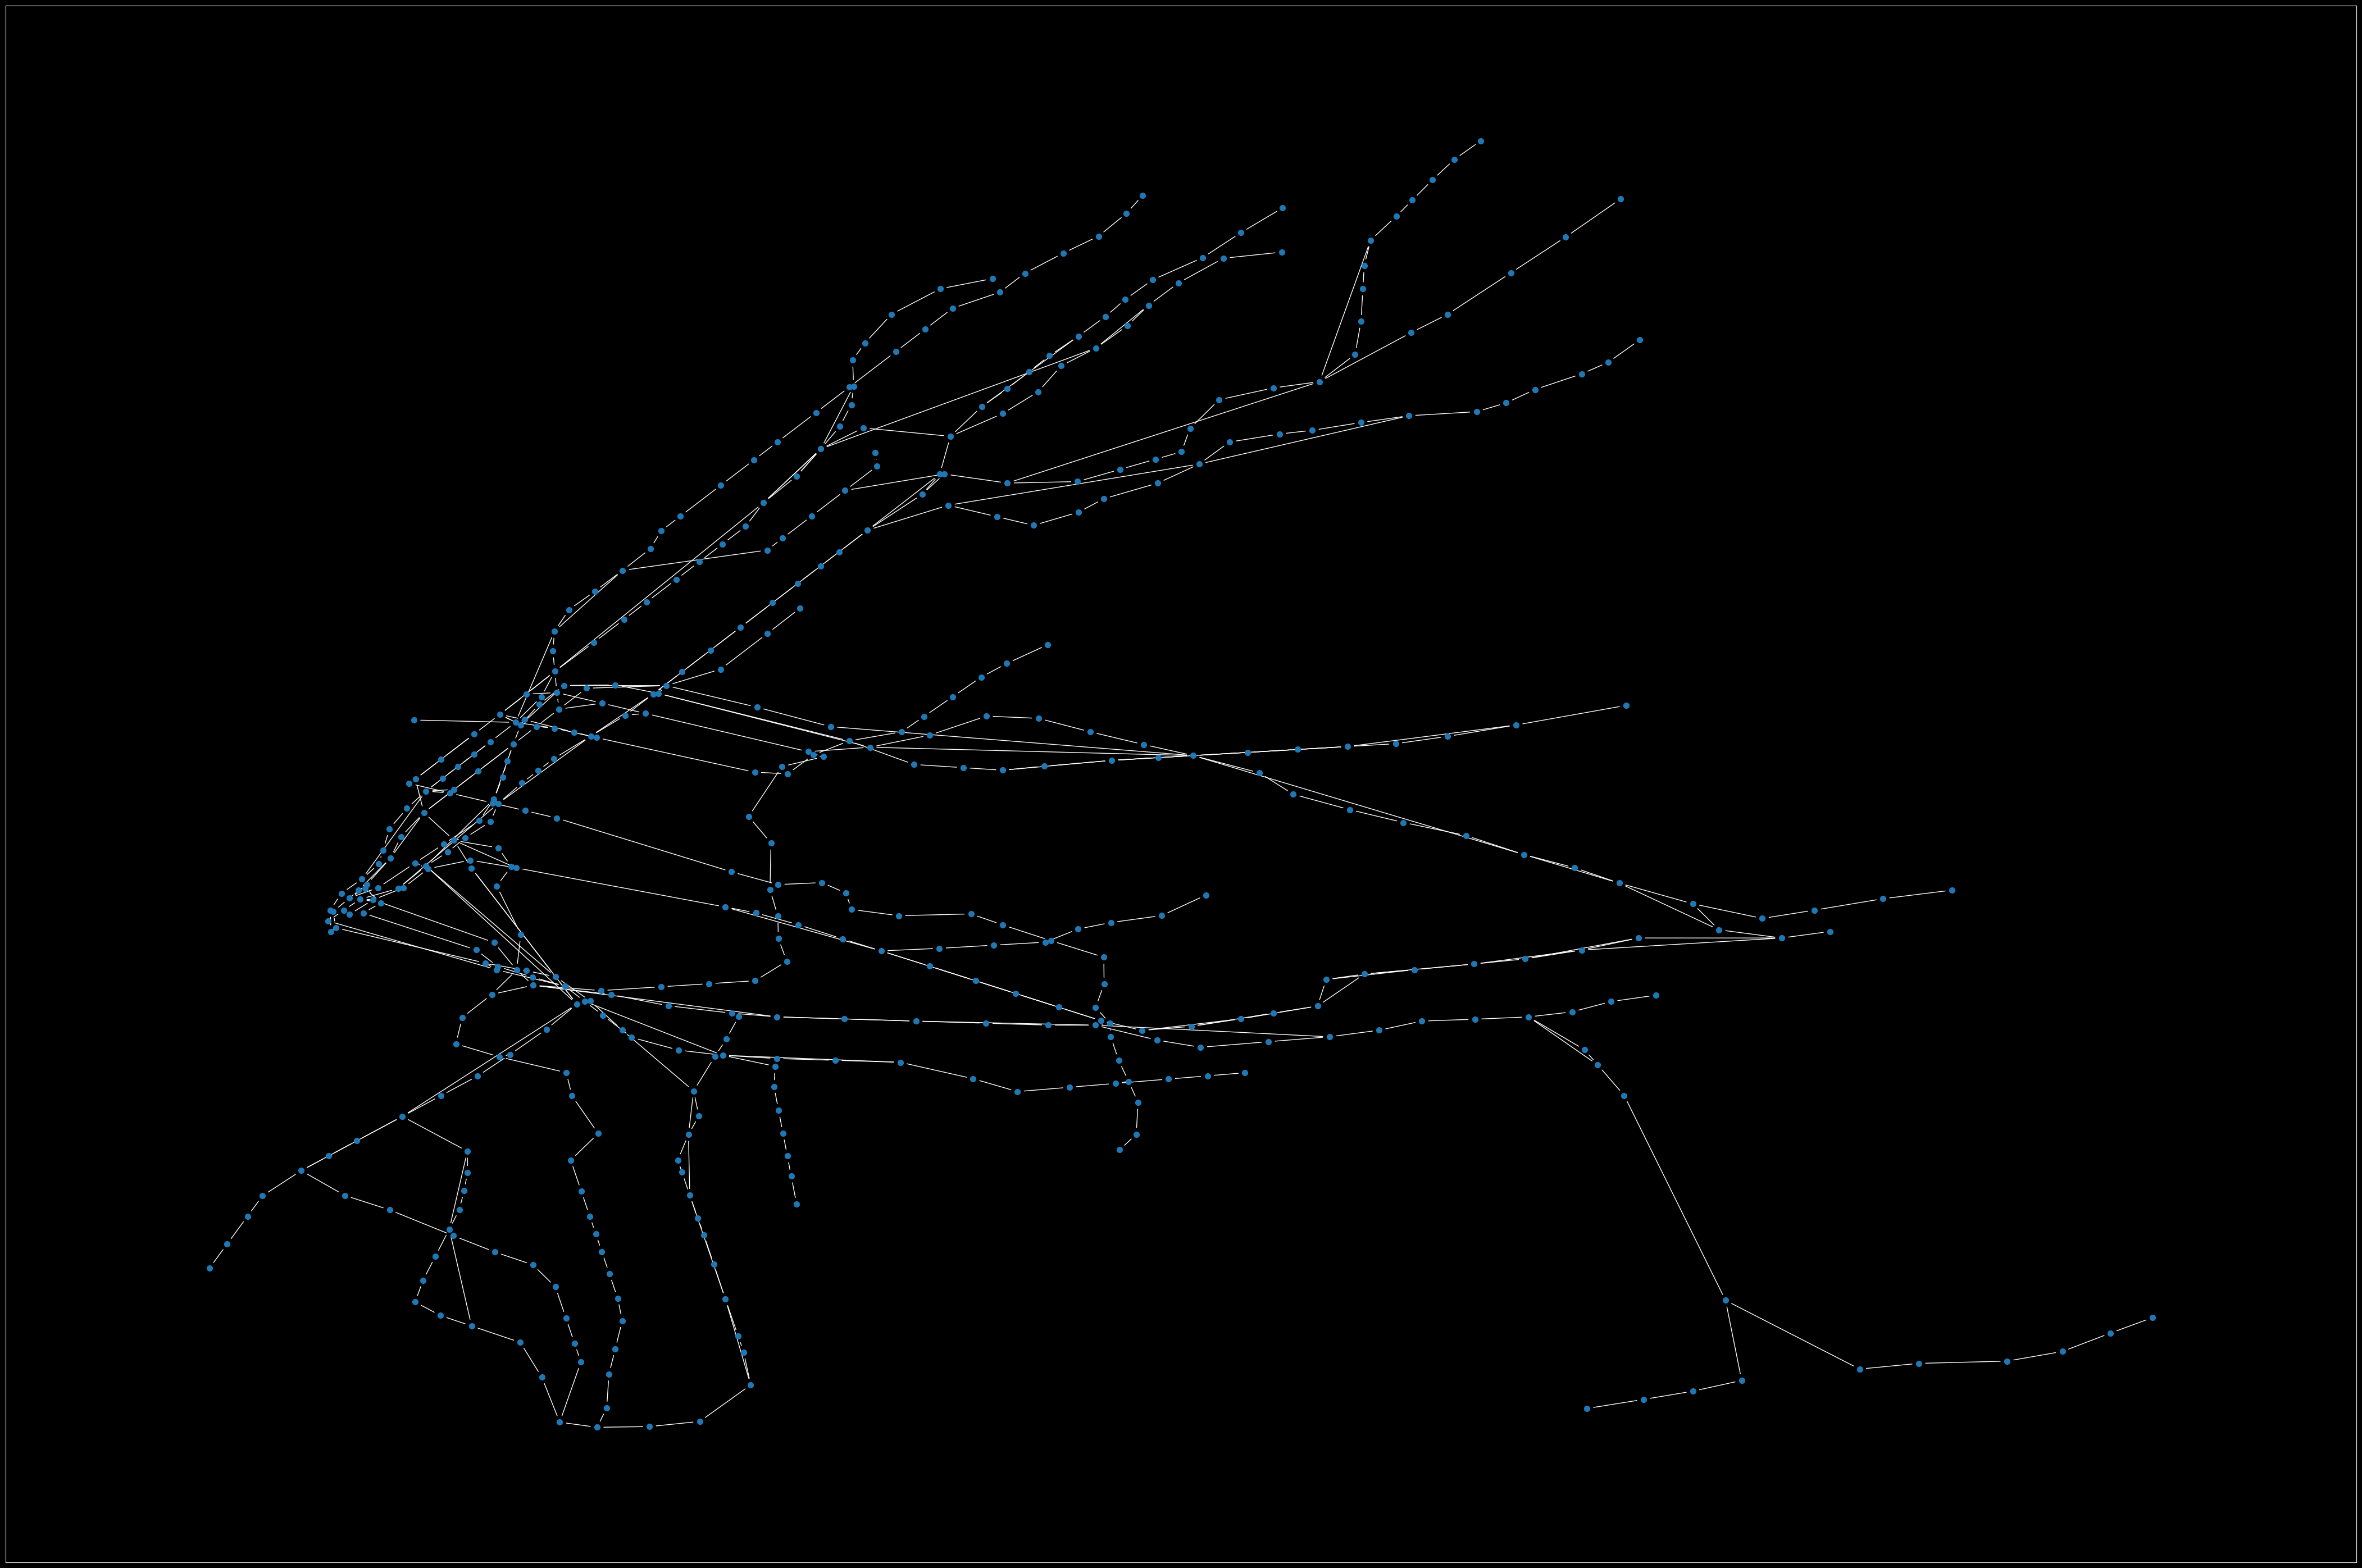

In [ ]:

node_pos = dict(G_visual.nodes.data())
st_pos = pd.DataFrame.from_dict(node_pos).T
st_pos = st_pos[['x','y']].T.to_dict()
coords = [list(list(st_pos.values())[n].values()) for n in range(len(st_pos))]
xylist = np.transpose(coords)
xrange = [min(xylist[0]),max(xylist[0])]
yrange = [min(xylist[1]),max(xylist[1])]
xylist[0] += 74
xylist[1] -= 40
xylist[0]*=10
coords = np.transpose(xylist)
coords = [tuple(i) for i in coords]
plt.figure(1, figsize=(54,36))
pos = dict(zip(G_visual.nodes, coords))

nx.draw_networkx_nodes(G_visual,node_size=50, pos = pos, label=True)
nx.draw_networkx_edges(G_visual, width=1, edge_color='w', pos=pos, edge_vmin=0)
plt.show()


In [ ]:
sorted(nx.degree(G_visual), key=lambda x: x[1], reverse=True)[:6]

[('127', 11), ('639', 9), ('710', 9), ('A12', 8), ('A38', 8), ('125', 7)]

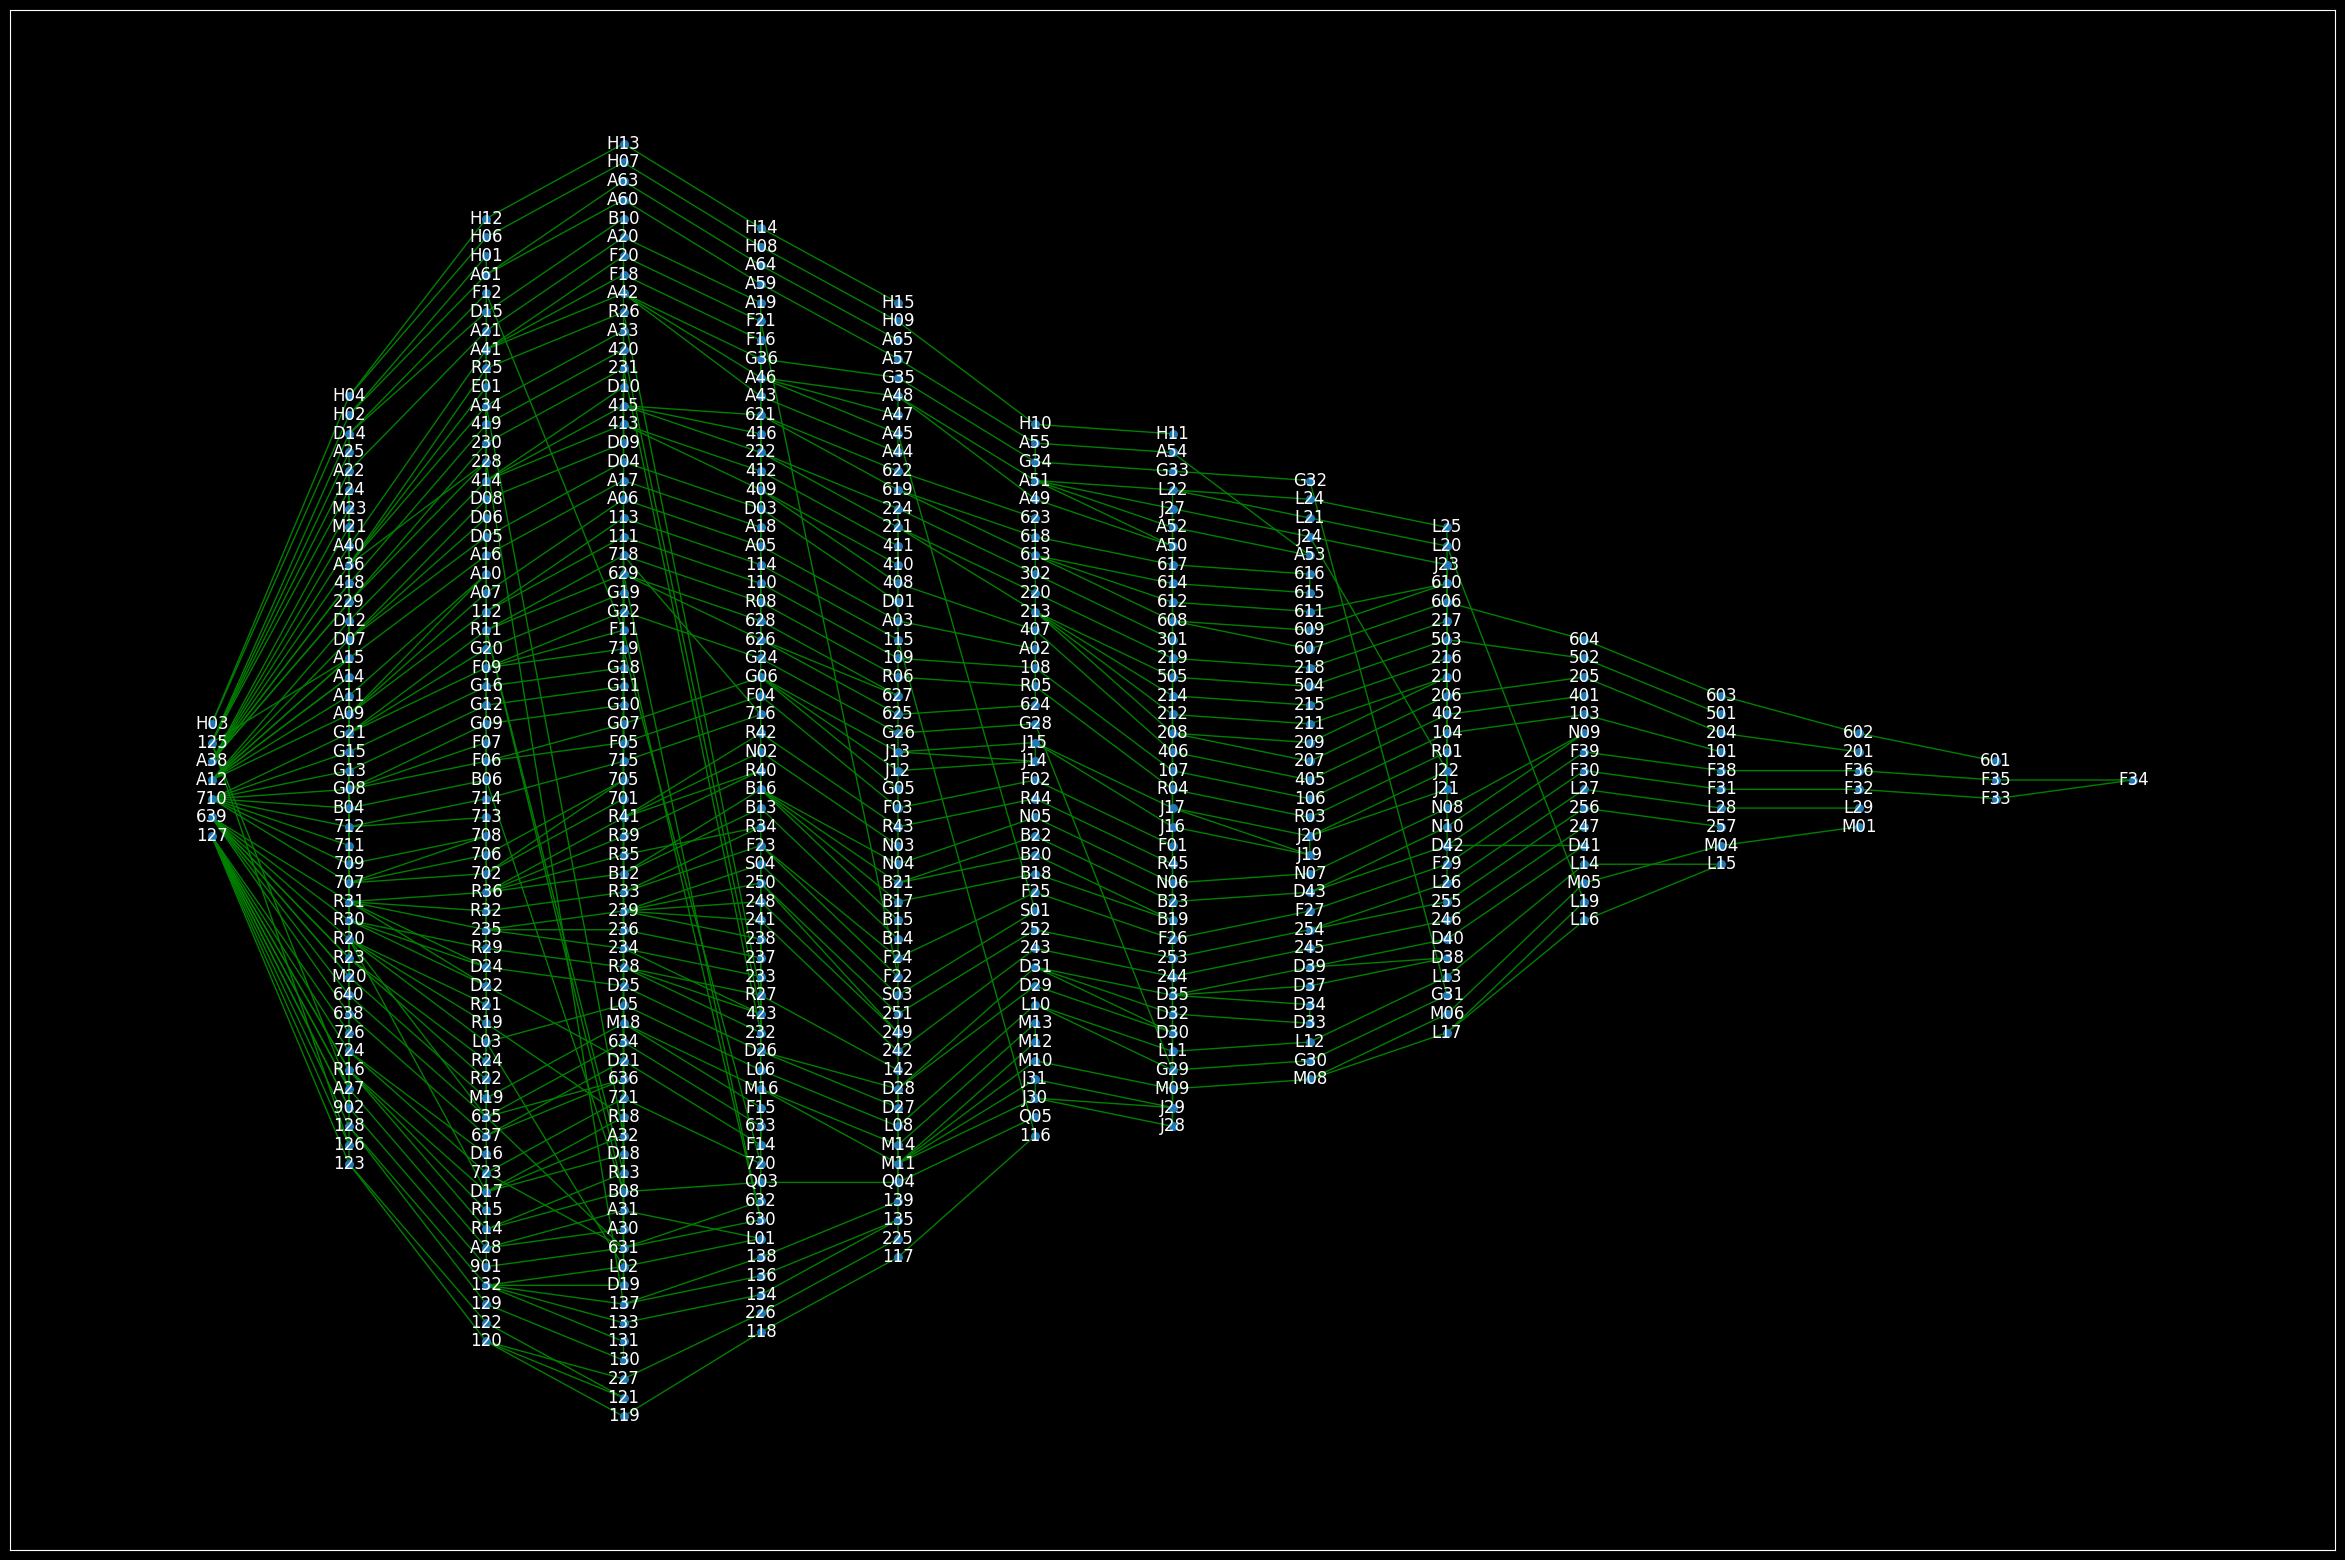

In [ ]:
plt.figure(2, figsize=(30,20))
connectedstops = dict(enumerate(nx.bfs_layers(G_visual, ['127', '639','710','A12', 'A38', '125', 'H03'])))
pos2 = nx.multipartite_layout(G_visual, connectedstops)
nx.draw_networkx(G_visual, with_labels=True, node_size=30, edge_color='g', font_color='w', width=1, pos = pos2)

## export

In [ ]:
import json

def serialize(obj):
    if isinstance(obj, np.int64):
         return int(obj)
    if not isinstance(obj, (str, int, float, bool)):
        return list(obj)
    else: return obj


G.name = "NYC Subway"
try: del G.graph['crs']
except KeyError:
	pass
data1 = nx.node_link_data(G, edges="edges")
with open('subwaygraph8to8.json', 'w') as f:
    json.dump(data1,f, default=serialize)

In [1278]:
G_adjusted.name = "NYC Subway_multi-edge"
try: del G_adjusted.graph['crs']
except KeyError:
	pass
data1 = nx.node_link_data(G_adjusted, edges="edges")
with open('subwaygraph_multi.json', 'w') as f:
    json.dump(data1,f, default=serialize)